#### This is a Jupyter Notebook running Python 3

To run a cell, type `Shift` + `Return`. Run the cell below to get started. This will initialize our environment

In [1]:
from workshop_utils import *
import pandas as pd; import seaborn as sns; import datetime
import matplotlib.pyplot as plt; import matplotlib.dates as mdates; import matplotlib.colors as colors; import matplotlib.ticker
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Make figures look good for hi-res displays.

## Statistics about all mappers who have made a HOT-related changeset

The query we just ran:
```sql
SELECT
    changesets.user,
    min(created_at) AS first_edit, 
    max(created_at) AS last_edit, 
    date_diff('day', min(created_at), max(created_at)) AS lifespan,
    sum(num_changes) AS total_edits
FROM 
    changesets
WHERE
    changesets.tags['comment'] LIKE '%hotosm%' -- hotosm changesets only
GROUP BY 
    changesets.user 
ORDER BY lifespan DESC
```

This query generated a CSV file with 140k rows, one per user who has made a HOT-related changeset. Now we want to obtain that CSV file, which was automatically saved to an Amazon S3 bucket.

### Getting the data from S3

The `load_dataframe_from_s3` function takes either the full URL: 

    https://us-east-2.console.aws.amazon.com/athena/query/results/23f6baab-b1c7-40b5-902c-42901f2447df/csv
    
Or just the 36 character `Query ID`:

    23f6baab-b1c7-40b5-902c-42901f2447df
    
This function downloads the query results to the `/www` directory (unless it already exists), and then returns a `Pandas DataFrame`. To run it, just paste either the URL or the query ID as a string (wrap in quotes) into the next cell: 

In [23]:
#This next cell loads the data
all_changesets = load_dataframe_from_s3('https://us-east-2.console.aws.amazon.com/athena/query/results/a5784e44-09a2-40d7-be80-fb586130b552/csv')
hot_changesets = load_dataframe_from_s3('150d2d31-2cf0-4e6e-ae48-11f63463484b')

Found file locally... Creating dataframe... done.  Found 5,207 rowsFound file locally... Creating dataframe... done.  Found 2,732 rows

In [25]:
hot_changesets.head()

,day,hot_changes,hot_changesets
0,2019-09-08 00:00:00.000,207212,862
1,2019-09-07 00:00:00.000,236303,964
2,2019-09-06 00:00:00.000,794325,4188
3,2019-09-05 00:00:00.000,724565,4639
4,2019-09-04 00:00:00.000,721965,4495


In [26]:
all_changesets['date'] = all_changesets.day.apply(lambda x: pd.Timestamp(x).date())
hot_changesets['date'] = hot_changesets.day.apply(lambda x: pd.Timestamp(x).date())

In [27]:
all_changesets.set_index('date',inplace=True)
hot_changesets.set_index('date',inplace=True)

In [29]:
df = all_changesets.join(hot_changesets[['hot_changes','hot_changesets']])

Since we know our data is indexed by user and that first_edit and last_edit are dates, let's clean it up: 

In [30]:
df['all-minus-hot'] = df.all_changes - df.hot_changes
# df.first_edit = df.first_edit.apply(lambda x: pd.Timestamp(x)) # cast to datetime
# df.last_edit = df.last_edit.apply(lambda x: pd.Timestamp(x))   # cast to datetime
# # simplify by day
# df['first_day'] = df.first_edit.apply(pd.Timestamp.date)
# df['last_day'] = df.last_edit.apply(pd.Timestamp.date)

In [31]:
#Let's see how we did: 
df.head(3)

,day,all_changes,all_changesets,hot_changes,hot_changesets,all-minus-hot
date,,,,,,
2019-09-08,2019-09-08 00:00:00.000,2336945,22172,207212.0,862.0,2129733.0
2019-09-07,2019-09-07 00:00:00.000,2437240,20830,236303.0,964.0,2200937.0
2019-09-06,2019-09-06 00:00:00.000,3680999,42487,794325.0,4188.0,2886674.0


In [32]:
df.sort_index(inplace=True)

(1200000, 4343175.651666666)

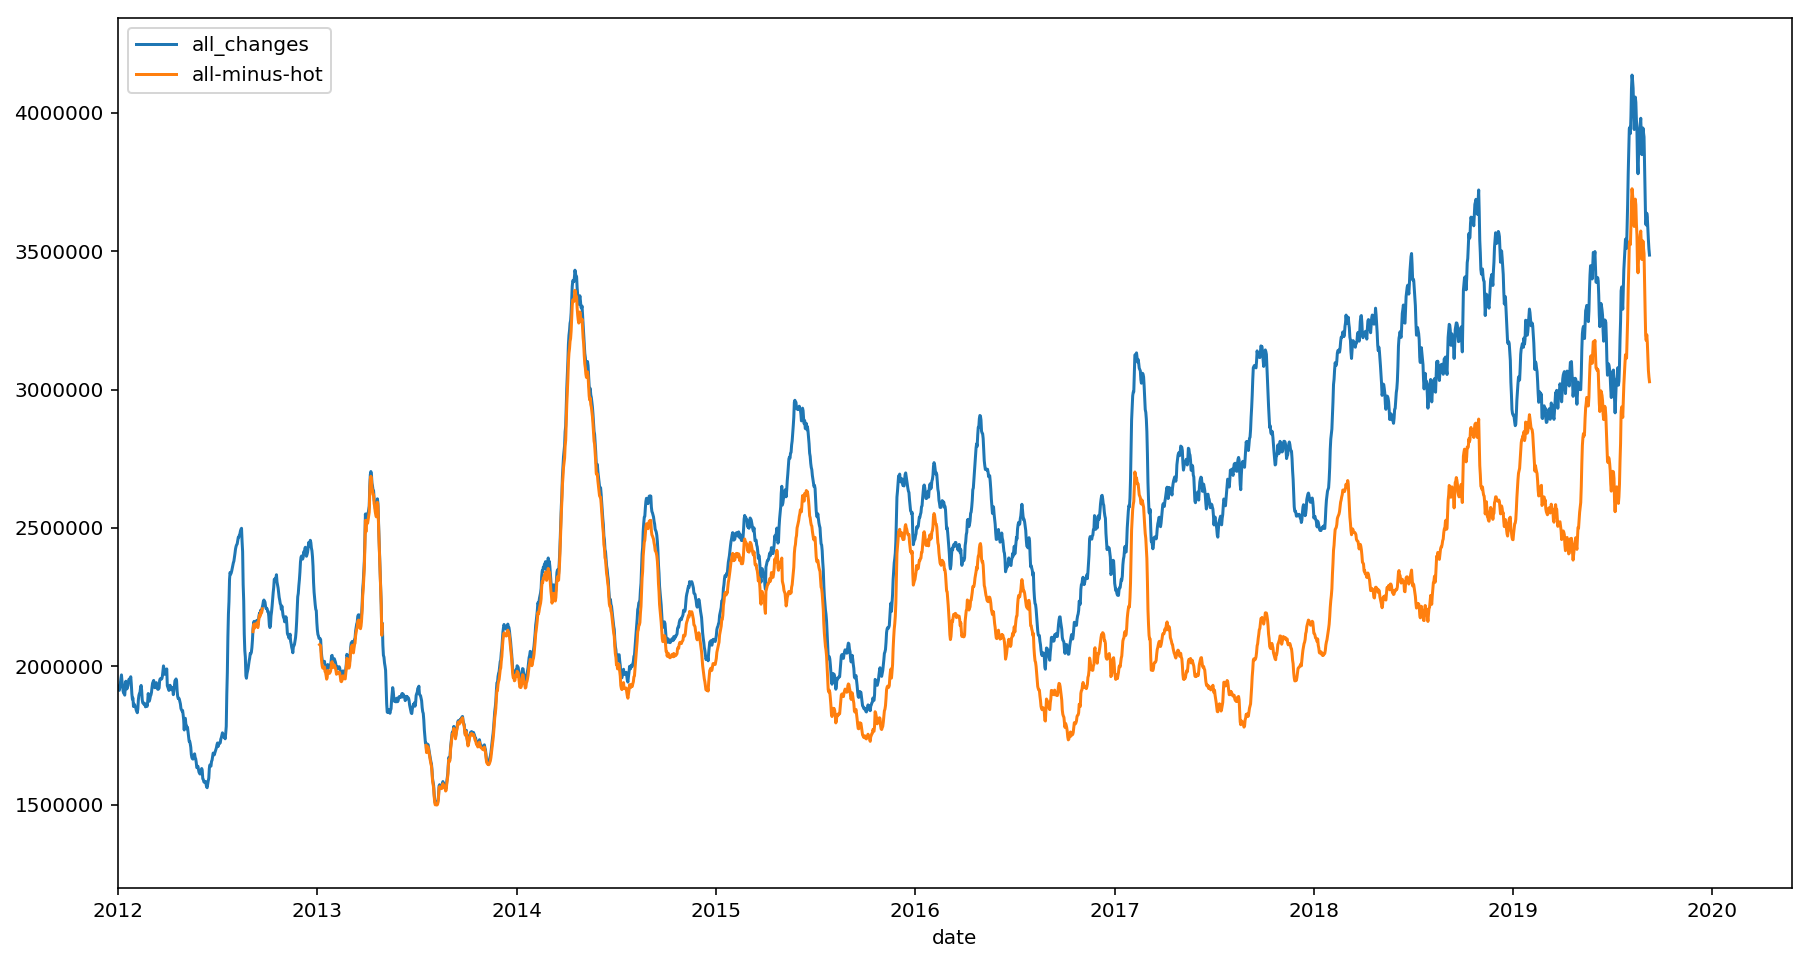

In [42]:
ax = df[['all_changes','all-minus-hot']].rolling(30).mean().plot(figsize=(15,8))
ax.set_xlim(datetime.datetime(2012,1,1));
ax.set_ylim(1200000)